# Week 7

Joshua Burden  
DSC530 Week 7
Bellevue University  
Catherine Williams  
06/19/2022

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT7

In [32]:
from __future__ import print_function, division

from os.path import basename, exists

%matplotlib inline

import numpy as np
import random 
import hypothesis

# import scatter
import thinkstats2

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hypothesis.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg2.py")





### Page 114: 9-1 (As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real…)
…)

    Exercise: As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

    To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

    What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [33]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [34]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [35]:
class DiffChisquaredPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat
    
    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat
    
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))
    
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [36]:
class DiffCorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat
    
    
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [37]:
# importing the NSFG data
import first
## Populating 3 dataframes from the NSFG file
live,first_birth,other_birth = first.MakeFrames()


In [38]:
def run_sample(sample, iters=1000):
    
    n = len(sample)
    firsts = sample[sample.birthord == 1]
    others = sample[sample.birthord != 1]
    
    ## Statitics is the difference in the mean pregnancy lengths for first and other births   
    data = firsts.prglngth.values, others.prglngth.values
    Null_ht_mean = DiffMeansPermute(data)
    p_mean = Null_ht_mean.PValue(iters = iters)

    ## Difference in the chi-squared lengths of pregnancies for first and other births   
    data = firsts.prglngth.values, others.prglngth.values
    Null_ht_chisq = DiffChisquaredPermute(data)
    p_chisq = Null_ht_chisq.PValue(iters = iters)

    
    
    ## Statitics is the difference in the standard deviation
    ## Null hypothesis is that the std is higher for first babies
    data = firsts.prglngth.values, others.prglngth.values
    Null_ht_sd = DiffStdPermute(data)
    p_std = Null_ht_sd.PValue(iters = iters)

    ## Null hypothesis is that there is no correlation between mother's weight and child's birth weight
    ## Test STatistics used here is Pearson's correlation
    ## We will be doing a two sided test
    live_sample = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live_sample.agepreg.values, live_sample.totalwgt_lb.values
    Null_ht_corr = DiffCorrelationPermute(data)
    p_corr = Null_ht_corr.PValue(iters = iters)    
  
    
    print ('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t' % (n,p_mean, p_chisq, p_std,p_corr ))
    # print(Null_ht_corr.actual, Null_ht_corr.MaxTestStat())
    # print(Null_ht_chisq.actual, Null_ht_chisq.MaxTestStat())
# looping through the sample
print('==============================================')
print('sample\tpmean\tpchi-sq\tpstd\tpcorr')
print('==============================================')
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    run_sample(sample)
    n //= 2

print('==============================================')

sample	pmean	pchi-sq	pstd	pcorr
9148	0.16	1.00	0.07	0.00	
4574	0.20	1.00	0.26	0.00	
2287	0.24	1.00	0.05	0.00	
1143	0.73	1.00	0.00	0.00	
571	0.91	1.00	0.16	0.00	
285	0.57	1.00	0.03	0.00	
142	0.60	1.00	0.03	0.00	


In [39]:
def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.DiffMeansPermute(data) # difference in means by permutation
    p1 = ht.PValue(iters=iters)            # Get the p-value

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = hypothesis.CorrelationPermute(data)  # correlations by permutation
    p3 = ht.PValue(iters=iters)               # Get the p-value
    

    print('%d\t%0.2f\t%0.2f' % (n, p1, p3))

In [40]:

thinkstats2.RandomSeed(18)

live, firsts, others = first.MakeFrames()

print('n\tP_Len\tCorr')
n = len(live)
for _ in range(7):      # iterate 7 times
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

n	P_Len	Corr
9148	0.16	0.00
4574	0.63	0.00
2287	0.55	0.00
1143	0.25	0.00
571	0.29	0.10
285	0.55	0.01
142	0.36	0.63


Correlation Test:
reported p-value is 0 out of a 1000 trials, there did not seem to be correlation 

Chi-squared:
p-value is says 1 for entire population because the actual value is > 1 which is statistically relevant

Mean and Stanard Deviations:
mean and standard deviations are erratic

P-values are shown above for corresponding sample size,n :
P_Len - Difference in mean pregnancy length
Corr - Correlation between mother's age and birth weight

Shown above here are the outccome of 2 tests we can clearly see that, power of hypothesis increases with size of sample. Test is positive with large sample size.

In this test, smallest size is '285' which yields positive test

### mPage 128: 10-1 (Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height

    Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. 
    How would you best present the estimated parameters for a model like this where one of the variables is log- transformed? 
    If you were trying to guess someone’s weight, how much would it help to know their height?
    Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent.
    In the BRFSS data, the variable name for these weights is finalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. 
    How much does correct weighting affect the estimates?

In [10]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

import brfss
import thinkplot

In [11]:
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
weights = np.log10(weights)

In [12]:
inter, slope = thinkstats2.LeastSquares(heights, weights)
inter, slope

(0.9930804163917974, 0.005281454169417895)

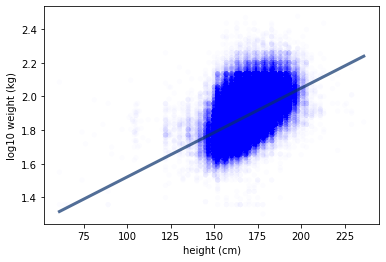

In [13]:
thinkplot.Scatter(heights, weights, alpha=0.01)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys)
thinkplot.Config(xlabel='height (cm)', ylabel='log10 weight (kg)', legend=False)

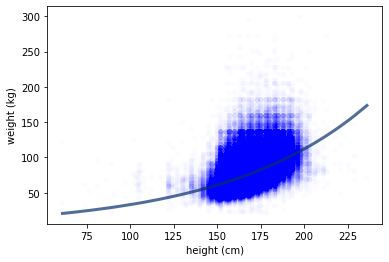

In [14]:
thinkplot.Scatter(heights, 10**weights, alpha=0.01)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys)
thinkplot.Config(xlabel='height (cm)', ylabel='weight (kg)', legend=False)

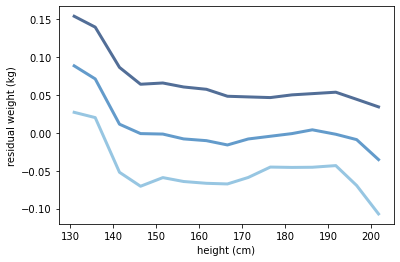

In [15]:
res = thinkstats2.Residuals(heights, weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

In [16]:
#Compute correlation

rho= thinkstats2.Corr(heights,weights)
rho

0.5317282605983519

In [17]:
#Compute coefficent of determination
r2 = thinkstats2.CoefDetermination(weights,res)
r2

0.28273494311893377

In [18]:
#confirm R^2 = p^2

rho**2 -r2

1.504352198367087e-14

In [19]:
#Compute Std(ys), which is the RMSE of predictions that don't use height.

std_ys = thinkstats2.Std(weights)
std_ys

0.10320725030004854

In [20]:
#Compute Std(res), the RMSE of predictions that do use height.

std_res = thinkstats2.Std(res)
std_res

0.08740777080416093

In [21]:
#How much does height information reduce RMSE? About 15%.

1 - std_res / std_ys

0.15308497658793052

In [22]:
#Use resampling to compute sampling distributions for inter and slope.

t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

{'xscale': 'linear', 'yscale': 'linear'}

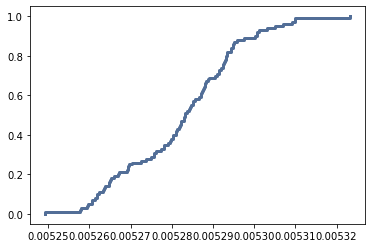

In [23]:
#Plot the sampling distribution of slope.

cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [24]:
#Compute the p-value of the slope.

pvalue = cdf[0]
pvalue

0

In [25]:
#Compute the 90% confidence interval of slope.

ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.00525978765621157, 0.0053049664861315494)

In [26]:
#Compute the mean of the sampling distribution.

mean = thinkstats2.Mean(slopes)
mean

0.0052823278966408795

In [27]:
#Compute the standard deviation of the sampling distribution, which is the standard error.

stderr = thinkstats2.Std(slopes)
stderr

1.409350540995795e-05

In [28]:

#Resample using sampling weights

def ResampleRowsWeighted(df, column='finalwt'):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample



In [29]:
#Summarize a sampling distribution.

def Summarize(estimates):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('mean', mean)
    print('stderr', stderr)
    print('ci', ci)

In [30]:
#Resample rows without weights, and summarize results.

estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean 168.95576282362214
stderr 0.0179049517521518
ci (168.92562501263163, 168.98690606115727)


In [31]:
#Resample rows with weights. The estimated mean height is almost 2 cm taller if we take into account the sampling weights, and this difference is much bigger than the sampling error.

estimates_weighted = [ResampleRowsWeighted(df).htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean 170.49713322823823
stderr 0.018811726337470882
ci (170.46224408334848, 170.52747377675377)
